# **LAB 3: Comparative Inference Benchmarking on ARM Server and Edge Devices**

## Introduction

Welcome to Lab 3 in our series on **Optimizing Generative AI Workloads with ARM Processors**! In this lab, we shift our focus to evaluating the performance constraints of generative AI inference between ARM-based server and edge devices. Specifically, we'll use the **OpenELM-3B** model alongside the popular **llama.cpp** framework to benchmark and compare inference characteristics on two different ARM environments: a high-performance Graviton server and a resource-constrained Raspberry Pi.

Throughout this lab, you will:

- **Benchmark Latency Metrics**: Measure and compare the overall inference latency, time-to-first-token (TTFT), and per-token decoding latency across devices.
- **Evaluate Memory Consumption**: Analyze how the OpenELM-3B model's memory footprint varies between an ARM server and an ARM-based edge device.
- **Compare ARM CPU Constraints**: Understand the practical limitations and trade-offs when deploying large language models on different ARM CPUs, from powerful server-class processors to limited edge devices.
- **Utilize llama.cpp Framework**: Leverage the llama.cpp framework for efficient model inference and performance measurement, allowing for cross-device comparisons.

This lab will guide you through setting up the necessary environments, running inference benchmarks on both the Raspberry Pi and Graviton server, and interpreting the results. By the end of the lab, you'll gain insights into:

- How hardware differences affect model performance
- Strategies for optimizing inference on both server and edge ARM devices
- Best practices for deploying large language models across diverse ARM architectures

---

### **Lab Objectives**

1. **Set Up Diverse ARM Environments**  
   Prepare and configure both a Raspberry Pi (edge device) and an ARM Graviton server for inference benchmarking with the OpenELM-3B model and llama.cpp framework.

2. **Benchmark Latency Metrics**  
   Measure key performance indicators, including total inference latency, time-to-first-token (TTFT), and per-token decoding latency, on both devices.

3. **Analyze Memory Consumption**  
   Monitor and compare memory utilization during model inference to assess resource constraints on server and edge devices.

4. **Compare Performance Constraints**  
   Understand the practical implications of deploying large language models on resource-constrained edge devices versus powerful server environments. Identify bottlenecks and optimization opportunities for each scenario.

5. **Document Findings and Insights**  
   Compile your observations, compare the differences in performance, and suggest strategies to mitigate limitations on edge devices while leveraging server capabilities.

---

### **Prerequisites**

- **Basic Understanding of Linux**: Familiarity with Linux command-line operations and system configuration.
- **Experience with C/C++ and Python Programming**: Ability to modify, compile, and execute code across different ARM platforms.
- **Fundamentals of AI Inference**: Knowledge of how inference works in large language models.
- **Completion of Labs 1 and 2 (Recommended)**: Prior experience with ARM intrinsics, quantization, and performance benchmarking for generative AI workloads.

---

**By the end of this lab**, you will have a comprehensive understanding of how ARM server and edge CPUs handle inference for large language models like OpenELM-3B. You will be equipped with the skills to benchmark and analyze latency, time-to-first-token, decoding performance, and memory consumption, enabling you to make informed decisions when deploying AI models across diverse ARM architectures.




## 1. Setting Up the Raspberry Pi for Inference Benchmarking

Before proceeding, ensure you have completed the [Lab 1 setup script](#) on your Raspberry Pi. If not, start by running the setup script:

```bash
./setup_pi5.sh
```

Once the script completes, activate the newly created virtual environment:

```bash
source pi5_env/bin/activate
```

This ensures that all required packages for the lab are preinstalled.

### Building the llama.cpp Inference Framework

If you haven't already, download and build the [llama.cpp](https://github.com/ggerganov/llama.cpp) inference framework with ARM CPU optimizations:

1. **Clone the repository:**

   ```bash
   git clone https://github.com/ggerganov/llama.cpp
   ```

2. **Configure the build:**

   ```bash
   cmake -B llama.cpp/build -S llama.cpp -DCMAKE_CXX_FLAGS="-mcpu=native" -DCMAKE_C_FLAGS="-mcpu=native"
   ```

3. **Compile the framework:**

   ```bash
   cmake --build llama.cpp/build --config Release -j$(nproc) -v
   ```

These commands build the framework optimized for your ARM CPU.

### Downloading the OpenELM-3B Model Weights

Next, download the large language model weights from Hugging Face. Follow these steps:

1. Create a Python file named `download_openelm.py` in the root directory with the following content:

   ```python
   from huggingface_hub import snapshot_download

   # Specify the target directory for downloading the model
   target_directory = "models/hf_models/OpenELM-3B-Instruct"

   # Download a snapshot of the model repository
   snapshot_download(
       repo_id="apple/OpenELM-3B-Instruct",
       local_dir=target_directory,
       revision="main",  # Optional: specify a branch, tag, or commit hash
       local_dir_use_symlinks=False  # Set to True if you want symlinks instead of file copies
   )
   ```

2. Run the script to start downloading the model weights:

   ```bash
   python download_openelm.py
   ```

   > **Note:** The download may take around 20 minutes, depending on your internet speed, as the model is large (~3 billion parameters).

### Converting and Quantizing the Model

Once the model is downloaded, convert it to the GGUF format and quantize it for inference:

1. **Convert the model to GGUF format:**

   ```bash
   mkdir -p models/gguf_models

   python llama.cpp/convert_hf_to_gguf.py models/hf_models/OpenELM-3B-Instruct/ \
       --outfile models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       --outtype f16
   ```

2. **Quantize the model using llama-quantize:**

   The quantization process reduces the model's size and computational requirements, which can improve inference speed on resource-constrained devices like the Raspberry Pi. Two types of quantization are demonstrated here:
   
   - **Q8_0 Quantization:** This reduces the model to 8-bit precision, balancing model size and performance. It typically offers faster inference with a moderate impact on accuracy.
   - **Q4_0 Quantization:** This reduces the model further to 4-bit precision, providing greater speed and memory savings at the expense of some accuracy.

   For Q8_0 quantization:
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf Q8_0
   ```

   For Q4_0 quantization:
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf Q4_0
   ```

### Prompting the Model

After quantization, you can prompt the different models. For example, to use the Q8_0 quantized model:

```bash
llama.cpp/build/bin/llama-cli \
    -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf \
    -p "Could you write a very simple program in C++ to print 'Hello, World!' in less than 10 lines of code?"
```

Follow similar steps for other prompts or to test the Q4_0 model. This setup process on the Raspberry Pi allows you to benchmark LLM inference on an edge device and later compare performance with an ARM Graviton server.




## 2. Setting Up the AWS Arm Graviton Server for Inference Benchmarking

If you have not already followed these steps in Lab 2, start by creating an AWS account and logging in as the root user. Next, set up an EC2 instance using a Graviton processor by following these steps:

1. Search for **EC2** in the AWS Management Console and click on **Launch Instance**.
2. Choose your operating system (AMI). Select **Ubuntu** and toggle the architecture box to **arm64**.
3. For the instance type, select a **m7g.xlarge** and allocate **32 GB** of persistent storage.
4. Launch the instance. Once the instance is created, click **Connect** to get the SSH command. It will look similar to:
   ```bash
   ssh -i "GravitonUbuntu.pem" ubuntu@ec2-13-53-171-129.eu-north-1.compute.amazonaws.com
   ```
5. Use the provided SSH command to connect to the instance.

### Setting Up the Server Environment

Once connected:

1. Clone the repository:
   ```bash
   git clone https://github.com/OliverGrainge/Generative_AI_on_arm.git
   ```
2. Change directory and run the server setup script:
   ```bash
   cd Generative_AI_on_arm
   ./setup_graviton.sh
   ```

### Building the llama.cpp Inference Framework

After setting up the server environment, clone and build the `llama.cpp` framework:

1. **Clone the repository:**
   ```bash
   git clone https://github.com/ggerganov/llama.cpp
   ```
2. **Configure the build:**
   ```bash
   cmake -B llama.cpp/build -S llama.cpp -DCMAKE_CXX_FLAGS="-mcpu=native" -DCMAKE_C_FLAGS="-mcpu=native"
   ```
3. **Compile the framework:**
   ```bash
   cmake --build llama.cpp/build --config Release -j$(nproc) -v
   ```

### Downloading the OpenELM-3B Model Weights

Assuming you've already created the `download_openelm.py` file from Section 1, proceed with:

1. Activate the virtual environment:
   ```bash
   source graviton_env/bin/activate
   ```
2. Run the download script:
   ```bash
   python scripts/download_openelm.py
   ```

### Converting and Quantizing the Model

Once the model has been downloaded:

1. **Convert the model to GGUF format:**
   ```bash
   mkdir models/gguf_models/
   python llama.cpp/convert_hf_to_gguf.py models/hf_models/OpenELM-3B-Instruct/ \
       --outfile models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       --outtype f16
   ```

2. **Quantize the model:**

   For **Q8_0 quantization:**
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf Q8_0
   ```

   For **Q4_0 quantization:**
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf Q4_0
   ```






Great if you have completed all the steps up untill now you should have a compile llama.cpp inference framework on both your local raspberry pi and a remote Arm Graviton Server with the 3B OpenELM model in floating point 16, Int8 and Int4 precisions. Next to compare how the performance differs between them we should calculate some metrics from them. A good metric to measure is the time to first token. This is the time it takes for the LLM to process the entire input prompt and output a single token. It is critical as it significantly impacts user experience and can for large input prompts be a large computational burden as the llm must process every single token in the input. Another important metric to measure is the generation latency. An LLM autoregressively predicts the next most likely character or token based on the previous context e.g the prompt and any previous responce tokens. It is usually measured in tokens per second and in accelerated by caching the previous activations required to generate the new token. This is called KV Caching as the keys and values of the previous tokens are required to compute the next one. Lucky for us, llama.cpp offers a way to measure this for us, using llama-bench. We can use it with the following command. I will run it locally as an example. 

In [3]:
!llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 4 -n 2

| model                          |       size |     params | backend    | threads |          test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | ------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           pp4 |         21.29 ± 0.23 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           tg2 |          5.31 ± 0.26 |

build: 1d850433 (4488)


Your output should look like this:

| model                          |       size |     params | backend    | threads |          test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | ------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           pp4 |         21.29 ± 0.23 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           tg2 |          5.31 ± 0.26 |

build: 1d850433 (4488)

In this example, there are two types of tests: **pp4** and **tg2**.

- **pp4**: This indicates the prefill stage and measures the time in tokens per second (t/s) it takes to run the forward pass on the input prompt. The number `4` in `pp4` represents the 4 input tokens used, specified by the `-p 4` argument passed to `llama-bench`.

- **tg2**: This indicates the generation stage and measures the time it takes to generate new tokens (t/s). The number `2` in `tg2` represents the number of tokens generated, specified by the `-n 2` argument passed to `llama-bench`.


We can now run a number of experiments. Remember in lab 2, we where able to partition matrix multiplications into different piecies of work, each of them able to be parallelized across KleidiAI microkernels. We can also acchieve this parallelization in the llama.cpp framework by using the --threads argument. Lets setup a benchmark file. 

In [18]:
%%writefile scripts/benchmark_openelm.sh
#!/bin/bash

# benchmark the floating point 16 model and write it into 
mkdir openelm_results
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q4_pi_results.txt
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q8_pi_results.txt 

# NOTE: we are not benchmarking f16 on Raspberry Pi5 as the benchmark takes too long
# llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-f16.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/f16_pi_results.txt 

 

Overwriting scripts/benchmark_openelm.sh


In [19]:
!chmod +x ./scripts/benchmark_openelm.sh
!./scripts/benchmark_openelm.sh

mkdir: cannot create directory ‘openelm_results’: File exists
| model                          |       size |     params | backend    | threads |          test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | ------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       1 |          pp12 |         11.49 ± 0.01 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       1 |           tg6 |          5.73 ± 0.04 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       2 |          pp12 |         21.47 ± 0.06 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       2 |           tg6 |          6.36 ± 0.15 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       3 |          pp12 |         24.94 ± 0.05 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |    

now you have got the local results. You should copy and past the following code into a file inside scripts/ on your graviton server you have connected to via ssh. e.g. Copy the cell below: 

In [61]:
#!/bin/bash
mkdir openelm_results

# benchmark the floating point 16 model and write it into 
mkdir openelm_results
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-f16.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/f16_grav_results.txt 
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q8_grav_results.txt 
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q4_grav_results.txt 

SyntaxError: invalid decimal literal (873662293.py, line 6)

then open a file with 

nano scripts/benchmark_openelm.sh 

here you can then paste your the contents of the above cell. Then to save and exit the file 
ctrl + o 
followed by 
ctrl + x

then you should make it executable then run it. 

chmod +x ./scripts/benchmark_openelm.sh 
./scripts/benchmark_openelm.sh

once that script has finished we can copy the results back to our pi for further analysis and comparison with the raspberry pi. you can do this with 

In [26]:
!scp -i "/Users/olivergrainge/keys/GravitonUbuntu.pem"  -r ubuntu@ec2-13-53-171-129.eu-north-1.compute.amazonaws.com:Generative_AI_on_arm/openelm_results/* ./openelm_results/

f16_grav_results.txt                          100% 1262    12.8KB/s   00:00    
q4_grav_results.txt                           100% 1262    11.6KB/s   00:00    
q8_grav_results.txt                           100% 1262    12.7KB/s   00:00    


now we have the results for both the local machine and the remote we can parse the results with the script already included in your repository 

In [20]:
!python scripts/parse_results.py openelm_results/f16_pi_results.txt
!python scripts/parse_results.py openelm_results/q8_pi_results.txt
!python scripts/parse_results.py openelm_results/q4_pi_results.txt

!python scripts/parse_results.py openelm_results/f16_grav_results.txt
!python scripts/parse_results.py openelm_results/q8_grav_results.txt
!python scripts/parse_results.py openelm_results/q4_grav_results.txt

Now that should have passed the benchmarking results into a pandas dataframe we can now plot the results. 

In [21]:
import pandas as pd 

df_pi_q8 = pd.read_csv("openelm_results/q8_pi_results.csv")
df_pi_q4 = pd.read_csv("openelm_results/q4_pi_results.csv")

df_grav_f16 = pd.read_csv("openelm_results/f16_grav_results.csv")
df_grav_q8 = pd.read_csv("openelm_results/q8_grav_results.csv")
df_grav_q4 = pd.read_csv("openelm_results/q4_grav_results.csv")

Now lets plot the prefill stage latency. 

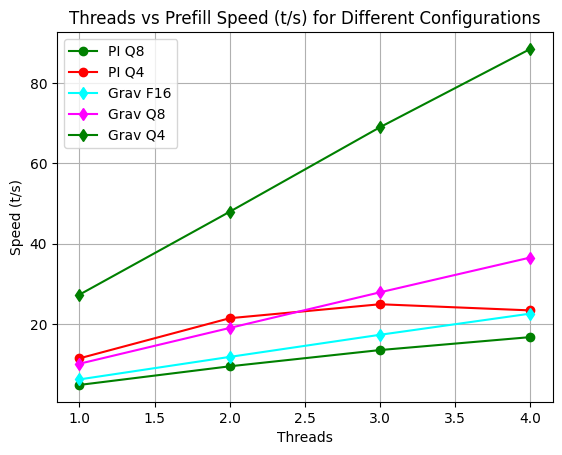

In [26]:

filtered_df_pi_q8 = df_pi_q8[df_pi_q8['Test'].str.startswith('pp')]
filtered_df_pi_q4 = df_pi_q4[df_pi_q4['Test'].str.startswith('pp')]

filtered_df_grav_f16 = df_grav_f16[df_grav_f16['Test'].str.startswith('pp')]
filtered_df_grav_q8 = df_grav_q8[df_grav_q8['Test'].str.startswith('pp')]
filtered_df_grav_q4 = df_grav_q4[df_grav_q4['Test'].str.startswith('pp')]

import matplotlib.pyplot as plt

# Assuming 'Threads' is the column for x-axis and 'Speed' for y-axis
def plot_speed_vs_threads(filtered_df, label, color, marker='o'):
    plt.plot(filtered_df['Threads'], filtered_df['Speed (t/s)'], label=label, marker=marker, color=color)

# Plot for pi datasets
plot_speed_vs_threads(filtered_df_pi_q8, 'PI Q8', 'green')
plot_speed_vs_threads(filtered_df_pi_q4, 'PI Q4', 'red')

# Plot for grav datasets
plot_speed_vs_threads(filtered_df_grav_f16, 'Grav F16', 'cyan', marker='d')
plot_speed_vs_threads(filtered_df_grav_q8, 'Grav Q8', 'magenta', marker='d')
plot_speed_vs_threads(filtered_df_grav_q4, 'Grav Q4', 'green', marker='d')

plt.xlabel('Threads')
plt.ylabel('Speed (t/s)')
plt.title('Threads vs Prefill Speed (t/s) for Different Configurations')
plt.legend()
plt.grid(True)
plt.show()

and now for token generation 

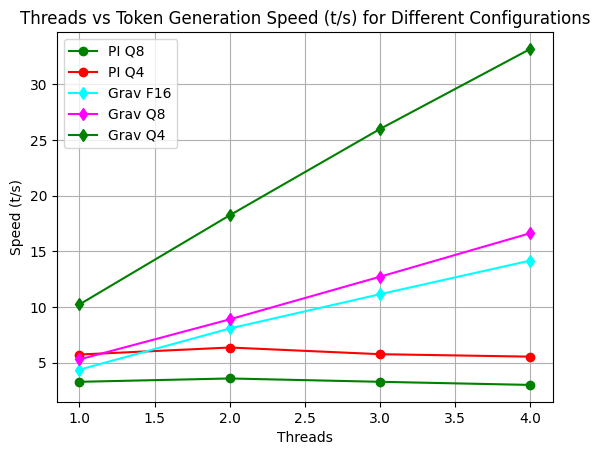

In [25]:

filtered_df_pi_q8 = df_pi_q8[df_pi_q8['Test'].str.startswith('tg')]
filtered_df_pi_q4 = df_pi_q4[df_pi_q4['Test'].str.startswith('tg')]

filtered_df_grav_f16 = df_grav_f16[df_grav_f16['Test'].str.startswith('tg')]
filtered_df_grav_q8 = df_grav_q8[df_grav_q8['Test'].str.startswith('tg')]
filtered_df_grav_q4 = df_grav_q4[df_grav_q4['Test'].str.startswith('tg')]

import matplotlib.pyplot as plt

# Assuming 'Threads' is the column for x-axis and 'Speed' for y-axis
def plot_speed_vs_threads(filtered_df, label, color, marker='o'):
    plt.plot(filtered_df['Threads'], filtered_df['Speed (t/s)'], label=label, marker=marker, color=color)

# Plot for pi datasets
plot_speed_vs_threads(filtered_df_pi_q8, 'PI Q8', 'green')
plot_speed_vs_threads(filtered_df_pi_q4, 'PI Q4', 'red')

# Plot for grav datasets
plot_speed_vs_threads(filtered_df_grav_f16, 'Grav F16', 'cyan', marker='d')
plot_speed_vs_threads(filtered_df_grav_q8, 'Grav Q8', 'magenta', marker='d')
plot_speed_vs_threads(filtered_df_grav_q4, 'Grav Q4', 'green', marker='d')

plt.xlabel('Threads')
plt.ylabel('Speed (t/s)')
plt.title('Threads vs Token Generation Speed (t/s) for Different Configurations')
plt.legend()
plt.grid(True)
plt.show()

Memory Consumption 

In [28]:
!llama.cpp/build/bin/llama-cli -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p "What is an artificial neural network?"

build: 4488 (1d850433) with cc (Debian 12.2.0-14) 12.2.0 for aarch64-linux-gnu
main: llama backend init
main: load the model and apply lora adapter, if any
llama_model_loader: loaded meta data with 32 key-value pairs and 326 tensors from models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = openelm
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = OpenELM 3B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = OpenELM
llama_model_loader: - kv   5:                         general.size_label str 